### In this problem participants had to build a model that predicts the total ride duration of taxi trips in New York City. 

### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
%matplotlib inline
import geopy

### Reading Data

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
full_data=[train,test]

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
del train['id']
del test['id']

In [6]:
for data in full_data:
    print data.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


There are no null values

In [7]:
for data in full_data:
    data['year']=data['pickup_datetime'].apply(lambda x:x.split('-')[0])
    data['month']=data['pickup_datetime'].apply(lambda x:x.split('-')[1])
    data['day']=data['pickup_datetime'].apply(lambda x:x.split('-')[2].split()[0])
    data['hour']=data['pickup_datetime'].apply(lambda x:x.split('-')[2].split()[1].split(':')[0])
for data in full_data:
    del data['pickup_datetime']
del train['dropoff_datetime']    

### Getting distance from latitude and longitude

In [8]:
from geopy.distance import great_circle
for data in full_data:
    data['distance']=data.apply(lambda row: great_circle((row[3],row[2]),(row[5],row[4])).kilometers,axis=1)

In [9]:
train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,03,14,17,1.498943
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,06,12,00,1.806016
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,01,19,11,6.386897
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,04,06,19,1.485917
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,03,26,13,1.188923


In [10]:
train['log_trip_duration']=np.log(train.trip_duration.values+1)

In [11]:
train.head(2)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,distance,log_trip_duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,03,14,17,1.498943,6.122493
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,06,12,00,1.806016,6.498282


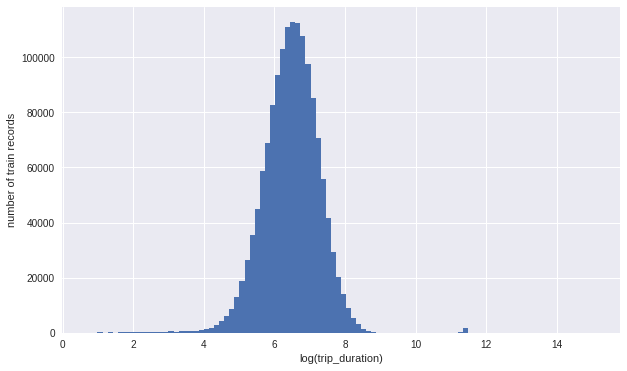

In [12]:
plt.figure(figsize=(10,6))
plt.hist(train.log_trip_duration,bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

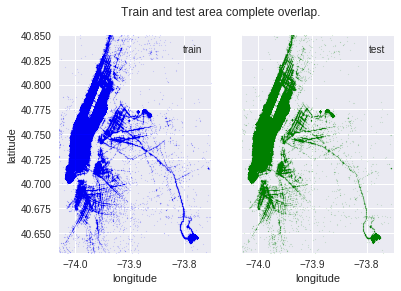

In [13]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values, train['pickup_latitude'].values,
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values, test['pickup_latitude'].values,
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

### Applying PCA on latitude and longitude

In [14]:
from sklearn.decomposition import PCA

In [15]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [16]:
pca=PCA()
pca.fit(coords)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
train['pickup_lat_pca']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_long_pca']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_lat_pca']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['dropoff_long_pca']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
test['pickup_lat_pca']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_long_pca']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_lat_pca']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['dropoff_long_pca']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]


In [18]:
train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hour,distance,log_trip_duration,pickup_lat_pca,pickup_long_pca,dropoff_lat_pca,dropoff_long_pca
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,03,14,17,1.498943,6.122493,0.007691,0.017053,0.007691,0.017053
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,06,12,00,1.806016,6.498282,0.007677,-0.012371,0.007677,-0.012371
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,01,19,11,6.386897,7.661527,0.004803,0.012879,0.004803,0.012879
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,04,06,19,1.485917,6.063785,0.038342,-0.029194,0.038342,-0.029194
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,03,26,13,1.188923,6.077642,-0.002877,0.041749,-0.002877,0.041749


In [19]:
for data in full_data:
    for i in ['year','month','day','hour']:
        data[i]=data[i].astype(int)

In [20]:
for data in full_data:
    data['store_and_fwd_flag']=data['store_and_fwd_flag'].map({'N':0,'Y':1})

In [21]:
for data in full_data:
    data.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [22]:
train['speed']=(3600*train.distance/train.trip_duration)

In [23]:
train.head(2)

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,year,month,day,hour,distance,log_trip_duration,pickup_lat_pca,pickup_long_pca,dropoff_lat_pca,dropoff_long_pca,speed
0,2,1,0,455,2016,3,14,17,1.498943,6.122493,0.007691,0.017053,0.007691,0.017053,11.859769
1,1,1,0,663,2016,6,12,0,1.806016,6.498282,0.007677,-0.012371,0.007677,-0.012371,9.806421


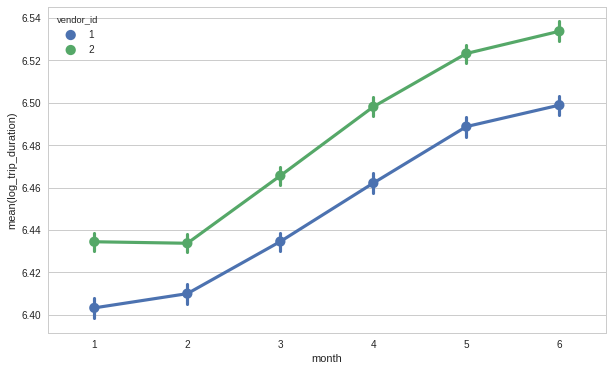

In [24]:
plt.figure(figsize=(10,6))
sns.set_style(style='whitegrid')
sns.pointplot(data=train,x='month',y='log_trip_duration',hue='vendor_id')
plt.show()

In [25]:
for data in full_data:
    data.loc[(data.month>=1)&(data.month<=2),'month_bin']=1
    data.loc[(data.month>=3)&(data.month<=5),'month_bin']=2
    data.loc[data.month==6,'month_bin']=3

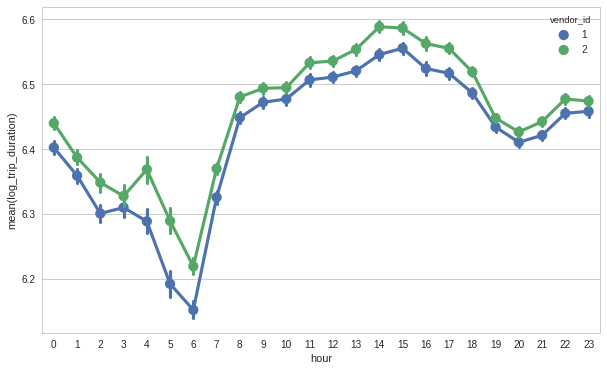

In [26]:
plt.figure(figsize=(10,6))
sns.set_style(style='whitegrid')
sns.pointplot(data=train,x='hour',y='log_trip_duration',hue='vendor_id')
plt.show()

In [27]:
for data in full_data:
    data.loc[(data.hour>=0)&(data.hour<=4),'hour_bin']=1
    data.loc[(data.hour>=5)&(data.hour<=8),'hour_bin']=2
    data.loc[(data.hour>=9)&(data.hour<=18),'hour_bin']=3
    data.loc[(data.hour>=19)&(data.hour<=23),'hour_bin']=4

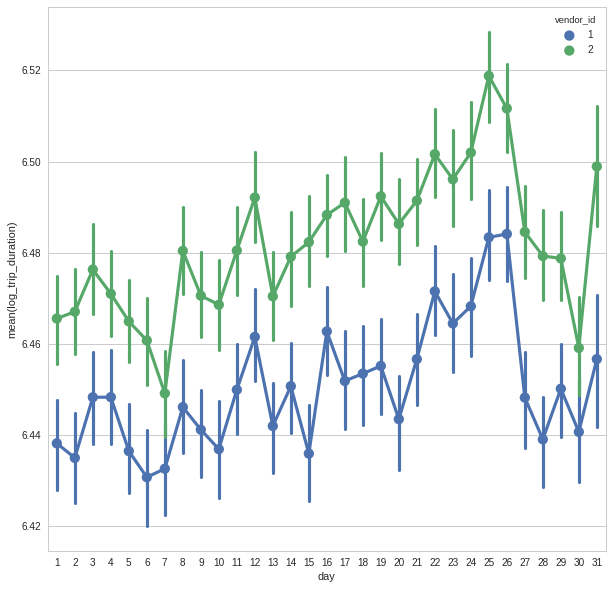

In [28]:
plt.figure(figsize=(10,10))
sns.set_style(style='whitegrid')
sns.pointplot(data=train,x='day',y='log_trip_duration',hue='vendor_id')
plt.show()

In [29]:
for data in full_data:
    data['day_bin']=0
    data.loc[(data.day>=22)&(data.day<=31),'day_bin']=1

In [30]:
train.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,year,month,day,hour,distance,log_trip_duration,pickup_lat_pca,pickup_long_pca,dropoff_lat_pca,dropoff_long_pca,speed,month_bin,hour_bin,day_bin
0,2,1,0,455,2016,3,14,17,1.498943,6.122493,0.007691,0.017053,0.007691,0.017053,11.859769,2.0,3.0,0
1,1,1,0,663,2016,6,12,0,1.806016,6.498282,0.007677,-0.012371,0.007677,-0.012371,9.806421,3.0,1.0,0
2,2,1,0,2124,2016,1,19,11,6.386897,7.661527,0.004803,0.012879,0.004803,0.012879,10.825250,1.0,3.0,0
3,2,1,0,429,2016,4,6,19,1.485917,6.063785,0.038342,-0.029194,0.038342,-0.029194,12.469233,2.0,4.0,0
4,2,1,0,435,2016,3,26,13,1.188923,6.077642,-0.002877,0.041749,-0.002877,0.041749,9.839366,2.0,3.0,1


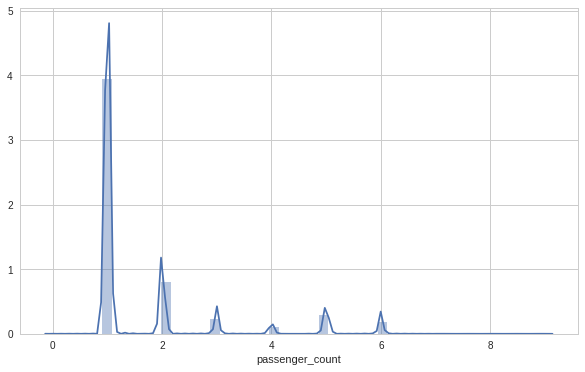

In [31]:
plt.figure(figsize=(10,6))
sns.distplot(train.passenger_count)

In [32]:
pd.value_counts(train.passenger_count>6)

False    1458639
True           5
Name: passenger_count, dtype: int64

In [33]:
train[train.passenger_count>6]

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,year,month,day,hour,distance,log_trip_duration,pickup_lat_pca,pickup_long_pca,dropoff_lat_pca,dropoff_long_pca,speed,month_bin,hour_bin,day_bin
433304,2,7,0,19,2016,6,7,10,0.002626,2.995732,0.200673,-0.002324,0.200673,-0.002324,0.497503,3.0,3.0,0
436047,2,9,0,560,2016,6,24,8,0.000000,6.329721,-0.257713,-0.095061,-0.257713,-0.095061,0.000000,3.0,2.0,1
489613,2,7,0,15,2016,5,8,22,0.001273,2.772589,0.068023,-0.032399,0.068023,-0.032399,0.305492,2.0,4.0,0
824904,2,7,0,25,2016,4,23,19,0.000000,3.258097,-0.342746,-0.002920,-0.342746,-0.002920,0.000000,2.0,4.0,1
826064,2,8,0,104,2016,1,1,1,5.953529,4.653960,0.018125,0.018450,0.018125,0.018450,206.083711,1.0,1.0,0


In [34]:
train=train.drop(train[train.passenger_count>6].index)

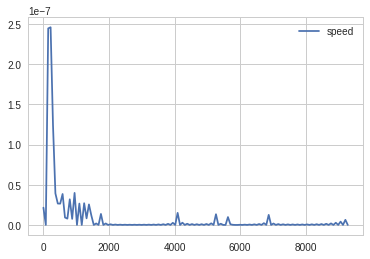

In [35]:
sns.kdeplot(data=train.speed)

In [36]:
train=train.drop(train[(train.speed>80)&(train.trip_duration<30)].index)

In [37]:
train=train.drop(train[train.speed>100].index)

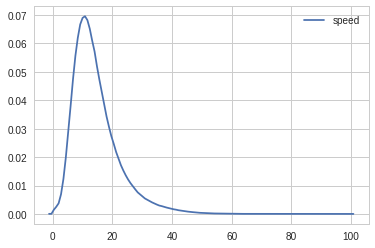

In [38]:
sns.kdeplot(train.speed)

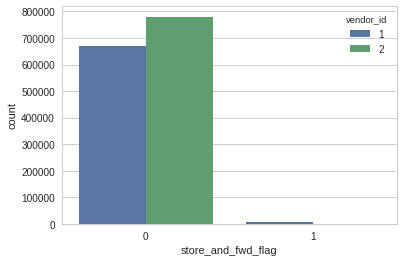

In [39]:
sns.countplot(train.store_and_fwd_flag,hue=train.vendor_id)

In [40]:
train.head(2)

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,year,month,day,hour,distance,log_trip_duration,pickup_lat_pca,pickup_long_pca,dropoff_lat_pca,dropoff_long_pca,speed,month_bin,hour_bin,day_bin
0,2,1,0,455,2016,3,14,17,1.498943,6.122493,0.007691,0.017053,0.007691,0.017053,11.859769,2.0,3.0,0
1,1,1,0,663,2016,6,12,0,1.806016,6.498282,0.007677,-0.012371,0.007677,-0.012371,9.806421,3.0,1.0,0


### Modelling

In [41]:
features=[i for i in train.columns if i not in ['trip_duration','speed','log_trip_duration','year']]

In [42]:
features

['vendor_id',
 'passenger_count',
 'store_and_fwd_flag',
 'month',
 'day',
 'hour',
 'distance',
 'pickup_lat_pca',
 'pickup_long_pca',
 'dropoff_lat_pca',
 'dropoff_long_pca',
 'month_bin',
 'hour_bin',
 'day_bin']

In [43]:
target=['log_trip_duration']

In [43]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(categorical_features=[0,2,3,4,5,11,12,13])

In [44]:
xtrain=ohe.fit_transform(train[features].values).toarray()

In [45]:
xtrain.shape

(1458430, 80)

In [46]:
xtest=train[target]

In [47]:
xtest=np.ravel(xtest)

In [48]:
xtest.shape

(1458430,)

In [49]:
from sklearn.ensemble import RandomForestRegressor
tree=RandomForestRegressor(n_estimators=10)
import time

In [51]:
t1=time.time()
print tree.fit(xtrain,xtest)
t2=time.time()
print t2-t1

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
331.582825899


In [52]:
ohe_t=OneHotEncoder(categorical_features=[0,2,3,4,5,11,12,13])
test_ohe=ohe.fit_transform(test[features].values).toarray()

In [54]:
pred=tree.predict(test_ohe)
pred.shape

(625134,)

In [55]:
submission=pd.read_csv('test.csv')
submission=submission['id']
submission=pd.DataFrame(submission)
submission['trip_duration']=np.exp(pred)+1
submission.to_csv('submission_3_d.csv',index=False)

### Due to the size of the data I was not able to tune the hyperparameters of the Random Forest, but tuning will surely increase the model's performance.
### This submission scored 0.47902 on LB